# **Analisis Pengaruh Sosio-Ekonomi terhadap Akses Sanitasi Layak di Indonesia dengan *Spatial Regression Graph Convolutional Neural Network* (SRGCNN)**

### 1. Import

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import math
import numpy as np, pandas as pd, math
import matplotlib.pyplot as plt
import geopandas as gp
import copy
import seaborn as sns
###
import torch
from torch import nn
import torch.nn.functional as F
###
from pysal.lib import weights
import pysal as ps
import esda
import spreg
###
from scipy import sparse
from scipy.sparse import coo_matrix
from scipy.sparse import diags
from scipy.sparse import csr_matrix
from scipy.spatial import distance
from scipy.sparse import eye
from scipy import sparse
from scipy import stats
from scipy.sparse import csgraph
###
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import median_absolute_error as mae
from sklearn.neighbors import NearestNeighbors

In [3]:
# enable cuda gpu accelaration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.set_printoptions(suppress=True)

In [4]:
device

device(type='cpu')

### 2. Functionalities

In [5]:
def mkdir(path):
    folder = os.path.exists(path)
    if not folder:
        os.makedirs(path)
    else:
        print ("---  There exist a folder of the same name!  ---")
def row_normalize(mx):
    '''Row-normalize sparse matrix'''
    rowsum = np.array(mx.sum(1))
    r_inv = (rowsum ** -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx
def unlog(x):
    '''return x to the power of 10'''
    return pow(10,x)

def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

def make_sym_matrix_boolean_sum(mx): # This will ensure the adjacent matrix to be symmetric no matter ways of definition
    return 1*np.logical_or(mx,mx.T)

def renormalized_trick_mx(mx): # This will add diagonal ones for the adjacent matrix
    return mx+np.eye(mx.shape[0])

def renormalized_trick_laplacian_old(mx):
    return np.eye(mx.shape[0])-csgraph.laplacian(mx,normed=True) # This will give D~^(-1/2)A~D~^(-1/2)

def renormalized_trick_laplacian(mx_tilde):
    degree_tilde = np.diag(np.sum(mx_tilde, axis=1))
    D_tilde_inv_sqrt=np.linalg.inv(np.sqrt(degree_tilde))
    return np.dot(D_tilde_inv_sqrt,mx_tilde).dot(D_tilde_inv_sqrt)

def step(model,optimizer,input_tensor,idx,target_tensor,adj): ##idx: use ids in the training set
    '''
    train with element-wise loss vector，return the mean scalar of the loss
    '''
    with torch.autograd.set_detect_anomaly(True):
        model.train()
        optimizer.zero_grad()
        output = model(input_tensor, adj)
        loss = F.mse_loss(output[idx], target_tensor[idx],reduce=False)
        loss.backward(torch.reshape(torch.ones(len(idx)).to(device),(len(idx),1)),retain_graph=False)
        optimizer.step()
        return loss.mean().item()

def evaluate(model,input_tensor,idx,target_tensor,adj):## idx: use ids in the validation set
    '''
    Monitor the loss of validation set during the training
    '''
    model.eval()
    output = model(input_tensor, adj)
    loss = F.mse_loss(output[idx], target_tensor[idx],reduce=False)
    return loss.mean().item()

def evaluate_MAE(model,input_tensor,idx,target_tensor,adj):## idx: use ids in the training set
    '''
    Monitor the Mean abosolute error of validation set during the training
    '''
    model.eval()
    output = model(input_tensor, adj)
    loss = F.l1_loss(output[idx], target_tensor[idx],reduce=False)
    return loss.mean().item()

def evaluate_MAPE(model,input_tensor,idx,target_tensor,adj):## idx: use ids in the validation set
    '''
    Monitor the Mean abosolute percentage error of validation set during the training
    '''
    model.eval()
    output = model(input_tensor, adj)
    MAPE = F.l1_loss(output[idx], target_tensor[idx],reduce=False)/target_tensor[idx]
    return MAPE.mean().item()

def return_results(model,input_tensor,idx,target_tensor,adj): ## return results as arrays
    '''
    call a model and get the predicted array and the ground truth array
    '''
    model.eval()
    output = model(input_tensor, adj)
    return output[idx].cpu().detach().numpy(),target_tensor[idx].cpu().detach().numpy()

### 3. Models

In [6]:
class GraphConvolution(nn.Module):
    """Basic graph convolution operation that incorporate both spatial lagged X
    and spatial lagged Y (to be used in the basic SRGCNNs model)"""
    def __init__(self, f_in, f_out, use_bias=True, activation=nn.ReLU()):
        super().__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out),requires_grad=True) #
        self.bias = nn.Parameter(torch.FloatTensor(f_out),requires_grad=True) if use_bias else None
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.constant_(self.weight,1)
        if self.use_bias: nn.init.constant_(self.bias,0)

    def forward(self, input, adj):
##      ---- self.method=='SRGCNN':
        support = torch.mm(input, self.weight)
        out = torch.mm(adj, support) #adj here has to be renormalized


        if self.use_bias: out.add_(self.bias) #
        if self.activation is not None:
            out=self.activation(out)
        return out

class GCN(nn.Module):
    """Basic SRGCNN model"""
    def __init__(self, f_in, n_classes, hidden=[16], dropouts=[0.0]):
        if hidden==[]:
            super().__init__()
            self.layers=[]
            self.dropouts=[]
            self.out_layer = GraphConvolution(f_in, n_classes, activation=nn.Sigmoid())# for spatial regression tasks: no activation func after the output layer
        else:
            super().__init__()
            layers = []
            for f_in,f_out in zip([f_in]+hidden[:-1], hidden):
                layers += [GraphConvolution(f_in, f_out)]

            self.layers = nn.Sequential(*layers)
            self.dropouts = dropouts
            self.out_layer = GraphConvolution(f_out, n_classes, activation=nn.Sigmoid())# for spatial regression tasks: no activation func after the output layer


    def forward(self, x, adj):
        for layer,d in zip(self.layers, self.dropouts):
            x = layer(x, adj)
            if d > 0: x = F.dropout(x, d, training=self.training, inplace=False)

        return self.out_layer(x, adj)

class GWGraphConvolution(nn.Module):
    """Geographically weighted graph convolution operation that
    adds locally parameterized weights to all the variables (to be used in the SRGCNNs-GW model)"""
    def __init__(self, f_in, f_out, use_bias=True, activation=nn.ReLU()):
        super().__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias
        self.activation = activation
        #########Geographically local parameters
        self.gwr_weight = nn.Parameter(torch.FloatTensor(x_tensor.shape[0], f_in),requires_grad=True)
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out),requires_grad=True) #
        self.bias = nn.Parameter(torch.FloatTensor(f_out),requires_grad=True) if use_bias else None
        self.initialize_weights()

    def initialize_weights(self):
        nn.init.constant_(self.weight,1)
        nn.init.constant_(self.gwr_weight,1)
        if self.use_bias: nn.init.constant_(self.bias,0)

    def forward(self, input, adj):
##      ---- self.method=='SRGCNN-GW':
        gwr_support=torch.mul(input,self.gwr_weight) # use torch.mul to enable element-wise product
        support=torch.mm(adj,gwr_support) #adj here has to be renormalized
        out=torch.mm(support,self.weight)


        if self.use_bias: out.add_(self.bias) #
        if self.activation is not None:
            out=self.activation(out)
        return out

class GWGCN(nn.Module):
    """SRGCNN-GW model"""
    def __init__(self, f_in, n_classes, hidden=[16], dropouts=[0.0]):
        if hidden==[]:
            super().__init__()
            self.layers=[]
            self.dropouts=[]
            self.out_layer = GWGraphConvolution(f_in, n_classes, activation=nn.Sigmoid())# for spatial regression tasks: no activation func after the output layer
        else:
            super().__init__()
            layers = []
            for f_in,f_out in zip([f_in]+hidden[:-1], hidden):
                layers += [GWGraphConvolution(f_in, f_out)]

            self.layers = nn.Sequential(*layers)
            self.dropouts = dropouts
            self.out_layer = GWGraphConvolution(f_out, n_classes, activation=nn.Sigmoid())# for spatial regression tasks: no activation func after the output layer


    def forward(self, x, adj):
        for layer,d in zip(self.layers, self.dropouts):
            x = layer(x, adj)
            if d > 0: x = F.dropout(x, d, training=self.training, inplace=False)

        return self.out_layer(x, adj)

### 4. Case Data
(For this open repository, we only show the airbnb case described in the Appendix section of paper)

In [7]:
shapefile = 'merged.shp'
gdf = gp.read_file(shapefile)
gdf.head()

,KAB_KOTA,Tahun,Persentase,Rata-rata,Pengeluara,Pengelua_1,Umur Harap,Harapan La,Indeks Pem,Tingkat Pe,latitude,longitude,geometry
0,Aceh Barat,2019,18.79,9.09,9692,1.272959e+06,67.93,14.59,71.22,7.409633,4.454275,96.152698,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."
1,Aceh Barat,2020,18.34,9.37,9516,1.370943e+06,71.56,14.60,71.38,7.296590,4.454275,96.152698,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."
2,Aceh Barat,2021,18.81,9.55,9593,1.533143e+06,71.57,14.61,71.67,7.091360,4.454275,96.152698,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."
3,Aceh Barat,2022,17.93,9.87,9775,1.513414e+06,71.76,14.63,72.34,6.093810,4.454275,96.152698,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."
4,Aceh Barat,2023,17.86,9.98,10085,1.524463e+06,71.89,14.64,72.88,6.072786,4.454275,96.152698,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."


In [8]:
# Simpan hanya variabel KAB_KOTA dan geometry
gdf = gdf[['KAB_KOTA', 'geometry']]
gdf.head()

,KAB_KOTA,geometry
0,Aceh Barat,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."
1,Aceh Barat,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."
2,Aceh Barat,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."
3,Aceh Barat,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."
4,Aceh Barat,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."


In [9]:
# Hapus duplikat dan simpan satu di antaranya
gdf = gdf.drop_duplicates(subset='KAB_KOTA')
gdf.head()

,KAB_KOTA,geometry
0,Aceh Barat,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."
5,Aceh Barat Daya,"MULTIPOLYGON (((96.80559 3.71758, 96.80444 3.7..."
10,Aceh Besar,"MULTIPOLYGON (((95.20544 5.28072, 95.20563 5.2..."
15,Aceh Jaya,"MULTIPOLYGON (((95.58431 4.61495, 95.58379 4.6..."
20,Aceh Selatan,"MULTIPOLYGON (((97.59461 2.80777, 97.59365 2.8..."


In [10]:
# Reset index
gdf = gdf.reset_index(drop=True)
gdf.head()

,KAB_KOTA,geometry
0,Aceh Barat,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."
1,Aceh Barat Daya,"MULTIPOLYGON (((96.80559 3.71758, 96.80444 3.7..."
2,Aceh Besar,"MULTIPOLYGON (((95.20544 5.28072, 95.20563 5.2..."
3,Aceh Jaya,"MULTIPOLYGON (((95.58431 4.61495, 95.58379 4.6..."
4,Aceh Selatan,"MULTIPOLYGON (((97.59461 2.80777, 97.59365 2.8..."


In [11]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   KAB_KOTA  514 non-null    object  
 1   geometry  514 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 8.2+ KB


---

In [12]:
db = pd.read_csv('Data Action - Data.csv')
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 13 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   Kabupaten/Kota                                                        514 non-null    object 
 1   Latitude                                                              514 non-null    float64
 2   Longitude                                                             514 non-null    float64
 3   Persentase Penduduk Miskin (Persen)                                   514 non-null    float64
 4   Rata-rata Lama Sekolah (Tahun)                                        514 non-null    float64
 5   Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang/Tahun)          514 non-null    object 
 6   Pengeluaran per Kapita/bulan                                          514 non-null    object 
 7  

In [13]:
# cek kabupaten/kota di gdf yang tidak ada di data db
gdf[~gdf['KAB_KOTA'].isin(db['Kabupaten/Kota'])]

,KAB_KOTA,geometry
362,Nduga,"POLYGON ((138.16124 -4.13568, 138.16103 -4.137..."


In [14]:
# ganti nama kolom KAB_KOTA menjadi Kabupaten/Kota
gdf = gdf.rename(columns={'KAB_KOTA': 'Kabupaten/Kota'})
gdf.head()

,Kabupaten/Kota,geometry
0,Aceh Barat,"POLYGON ((96.11425 4.14761, 96.11439 4.14799, ..."
1,Aceh Barat Daya,"MULTIPOLYGON (((96.80559 3.71758, 96.80444 3.7..."
2,Aceh Besar,"MULTIPOLYGON (((95.20544 5.28072, 95.20563 5.2..."
3,Aceh Jaya,"MULTIPOLYGON (((95.58431 4.61495, 95.58379 4.6..."
4,Aceh Selatan,"MULTIPOLYGON (((97.59461 2.80777, 97.59365 2.8..."


In [15]:
# ganti Nduga dalam gdf menjadi Nduga *
gdf.loc[gdf['Kabupaten/Kota'] == 'Nduga', 'Kabupaten/Kota'] = 'Nduga *'

In [16]:
# cek kabupaten/kota di gdf yang tidak ada di data db

gdf[~gdf['Kabupaten/Kota'].isin(db['Kabupaten/Kota'])]

,Kabupaten/Kota,geometry


In [17]:
# ganti geometri db menjadi geometri gdf
db = db.merge(gdf, on='Kabupaten/Kota')
db.head()

,Kabupaten/Kota,Latitude,Longitude,Persentase Penduduk Miskin (Persen),Rata-rata Lama Sekolah (Tahun),Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang/Tahun),Pengeluaran per Kapita/bulan,Umur Harapan Hidup/UHH (Tahun),Harapan Lama Sekolah (Tahun),Indeks Pembangunan Manusia,Tingkat Pengangguran Terbuka (TPT),Persentase Rumah Tangga yang Memiliki Akses terhadap Air Minum Layak,Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak,geometry
0,Simeulue,2.583333,96.083333,17.92,9.81,"7,686","1,049,164",69.57,14.28,68.06,5.85,83.10,72.67,"MULTIPOLYGON (((96.66509 2.12018, 96.66765 2.1..."
1,Aceh Singkil,2.358946,97.872160,19.15,8.70,"9,374","1,175,815",69.85,14.35,70.14,6.84,83.99,67.93,"MULTIPOLYGON (((97.39711 2.03835, 97.39588 2.0..."
2,Aceh Selatan,3.311506,97.351656,12.10,8.91,"8,712","869,676",70.33,14.70,68.44,4.73,82.44,74.54,"MULTIPOLYGON (((97.59461 2.80777, 97.59365 2.8..."
3,Aceh Tenggara,3.308867,97.698227,12.45,10.09,"8,566","990,523",72.62,14.27,71.05,5.00,88.04,65.08,"POLYGON ((97.82461 3.74953, 97.82177 3.74658, ..."
4,Aceh Timur,5.255443,95.988546,13.39,8.47,"9,436","1,046,189",72.13,13.07,69.32,8.03,82.46,70.01,"MULTIPOLYGON (((97.97568 4.55626, 97.97587 4.5..."


In [18]:
# remove Latitude and Longitude
db=db.drop(['Latitude','Longitude'],axis=1)

In [19]:
# convert db to geopandas
db=gp.GeoDataFrame(db,geometry='geometry')
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 12 columns):
 #   Column                                                                Non-Null Count  Dtype   
---  ------                                                                --------------  -----   
 0   Kabupaten/Kota                                                        514 non-null    object  
 1   Persentase Penduduk Miskin (Persen)                                   514 non-null    float64 
 2   Rata-rata Lama Sekolah (Tahun)                                        514 non-null    float64 
 3   Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang/Tahun)          514 non-null    object  
 4   Pengeluaran per Kapita/bulan                                          514 non-null    object  
 5   Umur Harapan Hidup/UHH (Tahun)                                        514 non-null    float64 
 6   Harapan Lama Sekolah (Tahun)                                          514 non-null

In [20]:
# convert 'Persentase Penduduk Miskin (Persen)', 'Persentase Rumah Tangga yang Memiliki Akses terhadap Air Minum Layak', and 'Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak' to 1/100
db['Persentase Penduduk Miskin (Persen)']=db['Persentase Penduduk Miskin (Persen)']/100
db['Persentase Rumah Tangga yang Memiliki Akses terhadap Air Minum Layak']=db['Persentase Rumah Tangga yang Memiliki Akses terhadap Air Minum Layak']/100
db['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak']=db['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak']/100

In [21]:
db.head()

,Kabupaten/Kota,Persentase Penduduk Miskin (Persen),Rata-rata Lama Sekolah (Tahun),Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang/Tahun),Pengeluaran per Kapita/bulan,Umur Harapan Hidup/UHH (Tahun),Harapan Lama Sekolah (Tahun),Indeks Pembangunan Manusia,Tingkat Pengangguran Terbuka (TPT),Persentase Rumah Tangga yang Memiliki Akses terhadap Air Minum Layak,Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak,geometry
0,Simeulue,0.1792,9.81,"7,686","1,049,164",69.57,14.28,68.06,5.85,0.8310,0.7267,"MULTIPOLYGON (((96.66509 2.12018, 96.66765 2.1..."
1,Aceh Singkil,0.1915,8.70,"9,374","1,175,815",69.85,14.35,70.14,6.84,0.8399,0.6793,"MULTIPOLYGON (((97.39711 2.03835, 97.39588 2.0..."
2,Aceh Selatan,0.1210,8.91,"8,712","869,676",70.33,14.70,68.44,4.73,0.8244,0.7454,"MULTIPOLYGON (((97.59461 2.80777, 97.59365 2.8..."
3,Aceh Tenggara,0.1245,10.09,"8,566","990,523",72.62,14.27,71.05,5.00,0.8804,0.6508,"POLYGON ((97.82461 3.74953, 97.82177 3.74658, ..."
4,Aceh Timur,0.1339,8.47,"9,436","1,046,189",72.13,13.07,69.32,8.03,0.8246,0.7001,"MULTIPOLYGON (((97.97568 4.55626, 97.97587 4.5..."


In [22]:
# get object column
object_col=db.select_dtypes(include=['object']).columns

# remove Kabupaten/Kota from object_col
object_col=object_col.drop('Kabupaten/Kota')

# remove ',' in object column and change to float64
for col in object_col:
    db[col]=db[col].str.replace(',','').astype('float64')

In [23]:
db.head()

,Kabupaten/Kota,Persentase Penduduk Miskin (Persen),Rata-rata Lama Sekolah (Tahun),Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang/Tahun),Pengeluaran per Kapita/bulan,Umur Harapan Hidup/UHH (Tahun),Harapan Lama Sekolah (Tahun),Indeks Pembangunan Manusia,Tingkat Pengangguran Terbuka (TPT),Persentase Rumah Tangga yang Memiliki Akses terhadap Air Minum Layak,Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak,geometry
0,Simeulue,0.1792,9.81,7686.0,1049164.0,69.57,14.28,68.06,5.85,0.8310,0.7267,"MULTIPOLYGON (((96.66509 2.12018, 96.66765 2.1..."
1,Aceh Singkil,0.1915,8.70,9374.0,1175815.0,69.85,14.35,70.14,6.84,0.8399,0.6793,"MULTIPOLYGON (((97.39711 2.03835, 97.39588 2.0..."
2,Aceh Selatan,0.1210,8.91,8712.0,869676.0,70.33,14.70,68.44,4.73,0.8244,0.7454,"MULTIPOLYGON (((97.59461 2.80777, 97.59365 2.8..."
3,Aceh Tenggara,0.1245,10.09,8566.0,990523.0,72.62,14.27,71.05,5.00,0.8804,0.6508,"POLYGON ((97.82461 3.74953, 97.82177 3.74658, ..."
4,Aceh Timur,0.1339,8.47,9436.0,1046189.0,72.13,13.07,69.32,8.03,0.8246,0.7001,"MULTIPOLYGON (((97.97568 4.55626, 97.97587 4.5..."


In [24]:
# Min Max Normalization for X variables (except for 'Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak')
scaler = preprocessing.MinMaxScaler()
col = db.columns.drop(['Kabupaten/Kota','Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak', 'Kabupaten/Kota', 'geometry'])
db[col] = scaler.fit_transform(db[col])

In [25]:
# the basic independent variables used for regression
variable_names = [
    'Persentase Penduduk Miskin (Persen)',
    'Rata-rata Lama Sekolah (Tahun)',
    'Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang/Tahun)',
    'Pengeluaran per Kapita/bulan',
    'Umur Harapan Hidup/UHH (Tahun)',
    'Harapan Lama Sekolah (Tahun)',
    'Indeks Pembangunan Manusia',
    'Tingkat Pengangguran Terbuka (TPT)',
    'Persentase Rumah Tangga yang Memiliki Akses terhadap Air Minum Layak'
]

db['log_PengeluaranKapitaDisesuaikan'] = np.log10(db['Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang/Tahun)'])
db['log_PengeluaranKapitaBulan'] = np.log10(db['Pengeluaran per Kapita/bulan'])
db['pengeluaranuhh'] = db['Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang/Tahun)']/db['Umur Harapan Hidup/UHH (Tahun)']
# the appended independent variables used for regression (may be used for feature engineering)
variable_names_append = [
    'Persentase Penduduk Miskin (Persen)',
    'Rata-rata Lama Sekolah (Tahun)',
    'Pengeluaran per Kapita Disesuaikan (Ribu Rupiah/Orang/Tahun)',
    'Pengeluaran per Kapita/bulan',
    'Umur Harapan Hidup/UHH (Tahun)',
    'Harapan Lama Sekolah (Tahun)',
    'Indeks Pembangunan Manusia',
    'Tingkat Pengangguran Terbuka (TPT)',
    'Persentase Rumah Tangga yang Memiliki Akses terhadap Air Minum Layak',
    'log_PengeluaranKapitaDisesuaikan',
    'log_PengeluaranKapitaBulan',
    'pengeluaranuhh'
]

<Axes: >

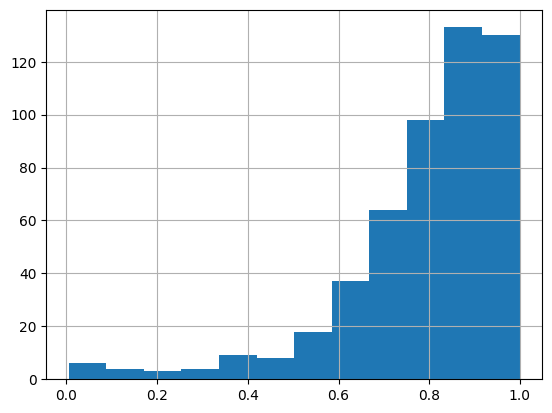

In [26]:
# Plot
(db['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak']).hist(bins=12)

In [27]:
db['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak'].describe()

count    514.000000
mean       0.791499
std        0.179875
min        0.004800
25%        0.721900
50%        0.837200
75%        0.917600
max        0.999200
Name: Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak, dtype: float64

The data is not normally distributed.

<Axes: >

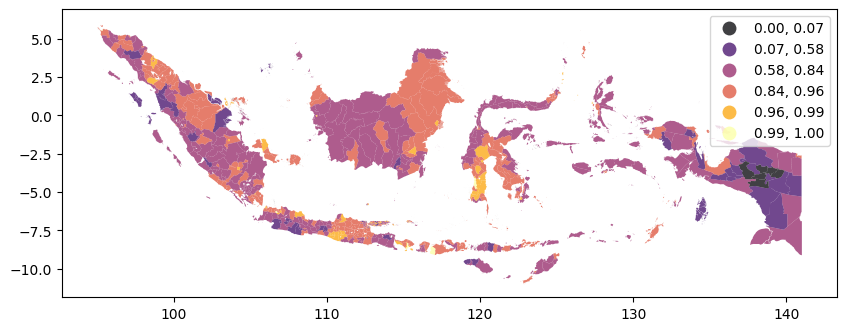

In [28]:
f,ax=plt.subplots(1,1,figsize=(10,10))
db.plot(column='Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak',cmap='inferno',scheme='percentiles',alpha=0.75,legend=True,ax=ax)

### 4. Settings

Spatial weights, variables and hyperparameters

In [29]:
knn=weights.KNN.from_dataframe(db,geom_col='geometry',k=5)

A_20nn_sym=make_sym_matrix_boolean_sum(knn.full()[0])
A_tilde_20nn_sym=renormalized_trick_mx(A_20nn_sym)
Laplacian_knn=renormalized_trick_laplacian(A_tilde_20nn_sym)
check_symmetric(Laplacian_knn)

adj=torch.FloatTensor(Laplacian_knn).to(device)

In [30]:
### The observations for data regression
x_tensor=torch.FloatTensor(db[variable_names].values.tolist()).to(device)
x_append_tensor=torch.FloatTensor(db[variable_names_append].values.tolist()).to(device)
y_tensor=torch.FloatTensor(db[['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak']].values.tolist()).to(device)
idx_all=torch.LongTensor(db.index.values).to(device)

In [31]:
### Params settings for the model on limited Xs
n_labels = 1 # #output feature dimension:log_price
n_features = len(variable_names)# #input feature dimensional vector
epochs = 18000 # #max training epoch

### 5. Train the Model
For demo usage, we here only show a simple case for SRGCNN-GW without further fine tuning; try `model=GCN(...)` for the basic SRGCNN model; try replace `x_tensor` with `x_append_tensor` and `n_features` for another scenario of independent variables; try change the array of hidden layers and corresponding dropouts in `GWGCN()` to test different model architectures; try more training epochs and smaller learning rate to obtain better fitting accuracy.

In [94]:
import torch

# Set random seed for reproducibility
torch.manual_seed(42)

# Step 1: Determine split sizes
total_samples = len(idx_all)
train_size = int(0.7 * total_samples)
val_size = int(0.15 * total_samples)
test_size = total_samples - train_size - val_size  # Ensure all samples are included

# Step 2: Shuffle indices
shuffled_indices = idx_all[torch.randperm(total_samples)]

# Step 3: Split into train, validation, and test indices
train_idx = shuffled_indices[:train_size]
val_idx = shuffled_indices[train_size:train_size + val_size]
test_idx = shuffled_indices[train_size + val_size:]

# Output the results to check
print("Train indices:", train_idx)
print("Validation indices:", val_idx)
print("Test indices:", test_idx)


Train indices: tensor([ 12, 375, 350, 414, 130, 201, 502, 105, 170, 342, 500,  57, 330, 424,
        245, 366, 381, 184, 473,  50,  71,  61,  59,  21, 503, 320,  39,  80,
        299, 213, 110, 232, 313, 281,  87, 159,  75, 501, 198, 324, 468, 178,
        219, 106, 271, 231, 249, 147, 371,   5, 448, 116, 302, 315,  60, 428,
        133, 401, 300, 332,   2, 220, 114, 325, 334, 363,  56, 368, 511, 175,
        207, 348, 400, 449, 422, 239, 187, 394, 444, 180, 248, 343, 318, 258,
        406, 438, 191, 498, 177, 272, 129, 417, 287,  85, 155, 469, 397, 392,
        471,  38, 278, 123, 119, 339,  45, 474, 391, 456,  96, 472, 433,  66,
        108, 113, 504, 285, 364,  55, 112, 282, 423, 455, 131,  81, 494, 221,
         69, 297, 319, 485, 509, 385, 202, 398, 480, 408, 252, 336, 376, 260,
         92, 316,  37, 419, 479,  93,  58, 140, 308, 396,  25, 483,  34,  29,
        166, 235, 390,  90, 490, 197, 210, 367, 393,  51, 357, 257, 261, 173,
        460, 369, 209, 477, 322,  62,  11, 165, 1

In [34]:
pip install contextily

   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   ---------------------------------------  122.9/125.4 kB 3.6 MB/s eta 0:00:01
   ---------------------------------------- 125.4/125.4 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
   ---------------------------------------- 40.3/40.3 kB 1.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


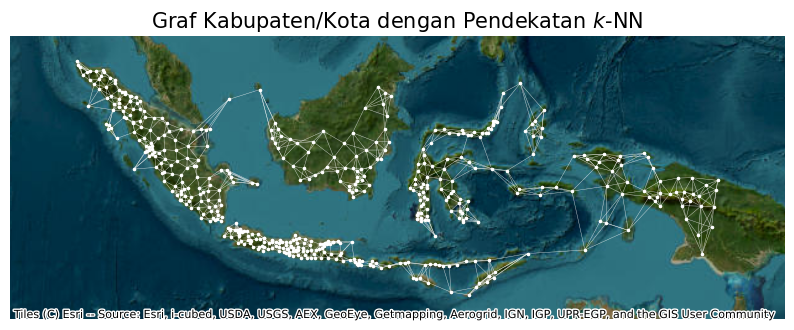

In [58]:
import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import contextily as ctx

# Misalkan db adalah geodataframe Anda dan A_20nn_sym adalah adjacency matrix
# Visualisasi poligon dari geodataframe 'db'
fig, ax = plt.subplots(figsize=(10, 10))

# Plotting polygons (hanya untuk border, tanpa warna)
db.plot(alpha=0, ax=ax)

# Konversi adjacency matrix dari KNN menjadi graf
G = nx.from_numpy_array(A_20nn_sym)

# Posisi node diambil dari centroid setiap poligon
pos = {i: (geom.centroid.x, geom.centroid.y) for i, geom in enumerate(db['geometry'])}

# Visualisasikan graf KNN di atas poligon
nx.draw_networkx_nodes(G, pos, node_size=2.5, node_color='white', ax=ax)
nx.draw_networkx_edges(G, pos, width=0.3, edge_color='white', alpha=0.8, ax=ax)

# Ubah CRS geodataframe ke EPSG:3857 untuk kompatibilitas dengan contextily
db = db.to_crs(epsg=3857)

# Tambahkan latar belakang peta dengan tampilan satelit
ctx.add_basemap(ax, crs=db.crs, source=ctx.providers.Esri.WorldImagery)

# Sesuaikan visualisasi
plt.title("Graf Kabupaten/Kota dengan Pendekatan $k$-NN", size=15)
plt.axis('off')  # Menampilkan sumbu
plt.show()

In [95]:
import numpy as np

class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_score = None
        self.early_stop = False
        self.counter = 0

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping activated.")

In [96]:
train_loss_arr = []
mape_arr = []

In [253]:
# Example of modifying the model architecture
model = GWGCN(n_features, n_labels, hidden=[n_features, 4*n_features, 8*n_features], dropouts=[0.1, 0.3, 0.5]).to(device)

# Example of modifying the optimizer learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# Initialize early stopping
early_stopping = EarlyStopping(patience=5000, verbose=True)

# Initialize variables for tracking the lowest MAPE
lowest_mean_global_MAPE = np.inf

train_loss_arr = []
mape_arr = []
min_global_MAPE_epoch = -1

for i in range(epochs):
    train_loss = step(model, optimizer, x_tensor, train_idx, y_tensor, adj)
    train_loss_arr.append(train_loss)
    
    global_MAPE = evaluate_MAPE(model, x_tensor, val_idx, y_tensor, adj)
    mape_arr.append(global_MAPE * 100)

    if global_MAPE < lowest_mean_global_MAPE:
        lowest_mean_global_MAPE = global_MAPE
        output, target = return_results(model, x_tensor, test_idx, y_tensor, adj)
        min_global_MAPE_epoch = i

    # Call early stopping
    early_stopping(global_MAPE)

    if early_stopping.early_stop:
        print(f"Early stopping at epoch {i}")
        break

    if i % 1000 == 0 or i == epochs - 1:
        print(f"Epoch: {i} -- Train Loss: {train_loss:.4f} -- Global MAPE: {global_MAPE * 100:.4f}%")

Epoch: 0 -- Train Loss: 0.0778 -- Global MAPE: 300.3870%
Epoch: 1000 -- Train Loss: 0.0123 -- Global MAPE: 133.4396%
Epoch: 2000 -- Train Loss: 0.0036 -- Global MAPE: 178.3934%
Epoch: 3000 -- Train Loss: 0.0029 -- Global MAPE: 171.5803%
Epoch: 4000 -- Train Loss: 0.0022 -- Global MAPE: 172.1359%
Epoch: 5000 -- Train Loss: 0.0021 -- Global MAPE: 164.0659%
Epoch: 6000 -- Train Loss: 0.0023 -- Global MAPE: 154.3078%
Early stopping activated.
Early stopping at epoch 6396


In [254]:
# Assuming your model is trained and named `model`
weights = model.layers[0].weight.data  # Access weights of the first layer
importance = torch.abs(weights).sum(dim=1)  # Summing the absolute weights

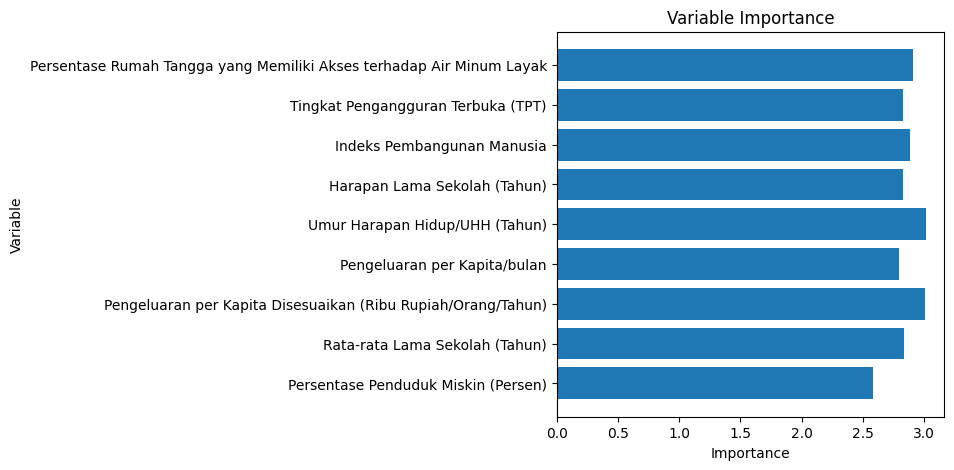

In [256]:
# Plot the importance
plt.figure(figsize=(5, 5))
plt.barh(variable_names, importance.cpu().numpy())
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.title("Variable Importance")
plt.show()

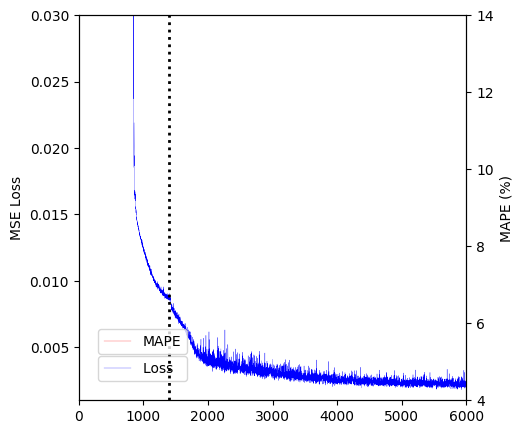

In [266]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(train_loss_arr,lw=0.2,color='b',alpha=1,label='Loss  ')
ax.set_xlim([0,6000])
ax.set_ylim([0.001,0.03])
ax2=ax.twinx()
ax2.plot(mape_arr,lw=0.2,color='r',alpha=1,label='MAPE')
ax2.set_ylim([4,14])
ax2.legend(loc=(0.05,0.12))
ax.legend(loc=(0.05,0.05))
ax.set_ylabel('MSE Loss')
ax2.set_ylabel('MAPE (%)')
plt.axvline(min_global_MAPE_epoch, linestyle="dotted", linewidth=2, color='black')

### 6. Output Statistics

The best results are recorded in the output array

In [267]:
mape=(mae(output,target)/target).mean()
mape # mean absolute percentage error between predicted y and the real y

0.084997475

Model goodness of fit

In [268]:
SSE=np.sum((target-output)**2)
SST=np.sum((db[['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak']].values-db[['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak']].values.mean())**2)

Rsq=1-SSE/SST
Rsq # R-square of model fit

0.9214356884401056

Moran's I of the model errors

In [269]:
print(output.shape)
print(target.shape)

(78, 1)
(78, 1)


In [270]:
import libpysal as ps
from libpysal.weights import KNN

# Extract test data from db using the test indices
db_test = db.iloc[test_idx.cpu()]

# Create KNN spatial weights matrix based on the test set geometries
knn_test = KNN.from_dataframe(db_test, geom_col='geometry', k=20)

# Check the created KNN
print(knn_test)

# Optional: if you want to visualize or verify the weights matrix
print(knn_test.full()[0])  # This will show the adjacency matrix form

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [1. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [271]:
Ierror = esda.moran.Moran(output-target, knn_test)
print('Errors  moransI: '+str(Ierror.I)+'  Z_I: '+str(Ierror.z_norm)+' p-value: '+str(Ierror.p_sim))

Errors  moransI: -0.015393130830603301  Z_I: -0.08418714296795349 p-value: 0.444


### 7. Visualization

In [272]:
output

array([[0.98755693],
       [0.44219318],
       [0.7945313 ],
       [0.8624131 ],
       [0.68085915],
       [0.83921874],
       [0.9003961 ],
       [0.8745619 ],
       [0.9109325 ],
       [0.88199663],
       [0.8242866 ],
       [0.36208263],
       [0.753158  ],
       [0.9693941 ],
       [0.96470815],
       [0.6980619 ],
       [0.61887985],
       [0.91491085],
       [0.8259665 ],
       [0.6264341 ],
       [0.9782274 ],
       [0.8950034 ],
       [0.8821155 ],
       [0.8358507 ],
       [0.73403925],
       [0.8273145 ],
       [0.5169676 ],
       [0.9093182 ],
       [0.74066556],
       [0.8291052 ],
       [0.95446765],
       [0.78283894],
       [0.77165294],
       [0.85028964],
       [0.91882384],
       [0.7700512 ],
       [0.3589938 ],
       [0.9922593 ],
       [0.5803066 ],
       [0.82622606],
       [0.81357855],
       [0.9191018 ],
       [0.79752487],
       [0.9109325 ],
       [0.8408608 ],
       [0.92494947],
       [0.87588984],
       [0.552

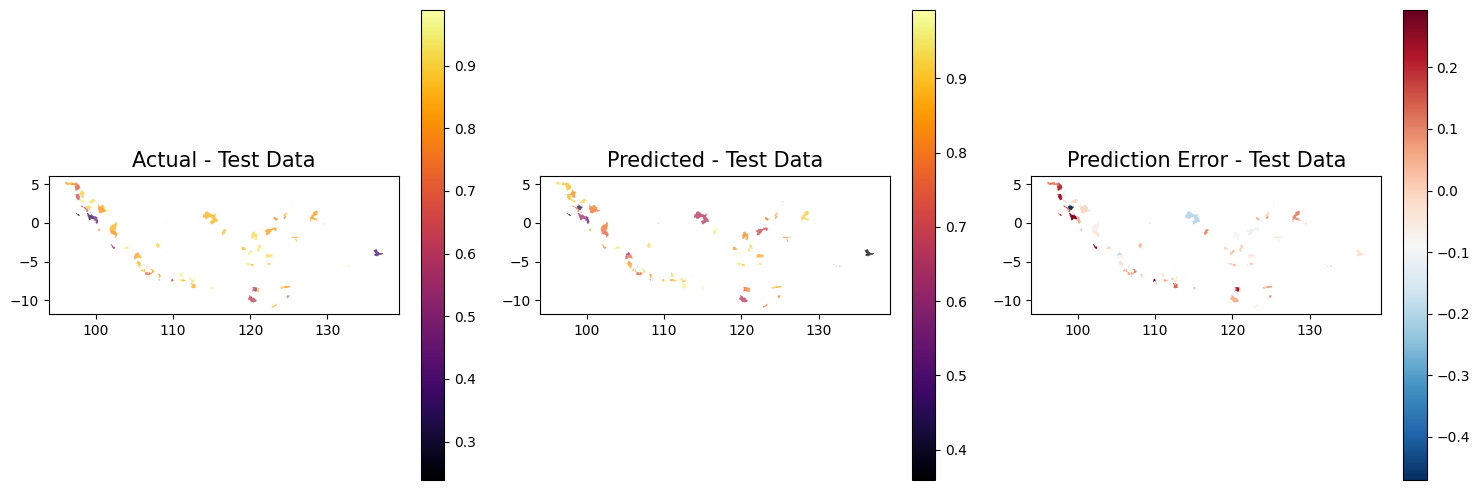

In [273]:
# Extract test data
dbplot_test = db_test.loc[:, ['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak', 'geometry']].copy()
dbplot_test['pred'] = output  # predicted values for the test set
dbplot_test['error'] = output - db_test[['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak']].values  # errors for the test set

# Create a figure for plotting
f, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot real values of 'Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak'
dbplot_test.plot(column='Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak', cmap='inferno', alpha=0.75, legend=True, ax=ax[0])
ax[0].set_title('Actual - Test Data', fontsize=15)

# Plot predicted values from the model
dbplot_test.plot(column='pred', cmap='inferno', alpha=0.75, legend=True, ax=ax[1])
ax[1].set_title('Predicted - Test Data', fontsize=15)

# Plot errors (actual - predicted)
dbplot_test.plot(column='error', cmap='RdBu_r', alpha=1, legend=True, ax=ax[2])
ax[2].set_title('Prediction Error - Test Data', fontsize=15)

# Display the plots
plt.tight_layout()
plt.show()

In [160]:
# Min and max prediction absolute error
abs_error = np.abs(output - target)
min_error = np.min(abs_error)
max_error = np.max(abs_error)

print(f"Min error: {min_error}")
print(f"Max error: {max_error}")

Min error: 0.0013169050216674805
Max error: 0.4694599509239197


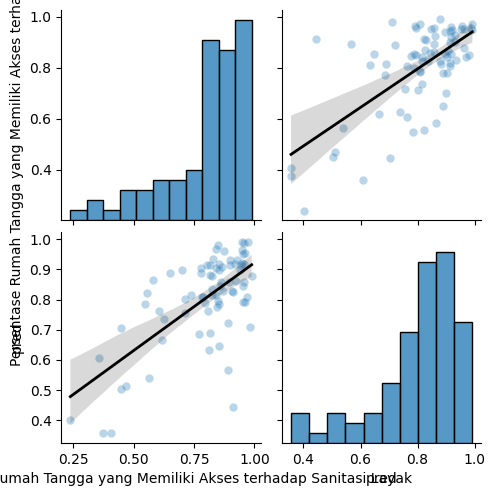

In [161]:
# Buat pairplot tanpa kolom 'error', jika ada
sns.pairplot(dbplot_test.drop('error', axis=1, errors='ignore'), 
             diag_kind="hist", 
             kind='reg', 
             plot_kws={'scatter_kws': {'linewidths': 0, 'alpha': 0.3}, 
                        'line_kws': {'color': 'black', 'lw': 2}})


In [301]:
# Parameter Estimated
print(model.layers[0].gwr_weight)
print(model.layers[0].weight)
print(model.layers[0].bias)


Parameter containing:
tensor([[0.1849, 0.2142, 0.1188,  ..., 0.2085, 0.1995, 0.2188],
        [0.1866, 0.1972, 0.1585,  ..., 0.1993, 0.1956, 0.2051],
        [0.2029, 0.2642, 0.1937,  ..., 0.2635, 0.2417, 0.2732],
        ...,
        [0.3027, 0.2149, 0.1719,  ..., 0.2665, 0.2650, 0.3029],
        [0.3091, 0.2073, 0.0604,  ..., 0.2698, 0.1971, 0.3113],
        [0.2810, 0.3106, 0.3076,  ..., 0.3089, 0.3126, 0.3072]],
       requires_grad=True)
Parameter containing:
tensor([[0.2891, 0.2835, 0.2783, 0.2857, 0.2915, 0.2854, 0.2894, 0.2893, 0.2923],
        [0.3142, 0.3130, 0.3116, 0.3151, 0.3195, 0.3157, 0.3158, 0.3138, 0.3166],
        [0.3328, 0.3332, 0.3324, 0.3339, 0.3384, 0.3356, 0.3358, 0.3315, 0.3354],
        [0.3098, 0.3074, 0.3050, 0.3099, 0.3176, 0.3104, 0.3116, 0.3095, 0.3119],
        [0.3327, 0.3341, 0.3322, 0.3347, 0.3376, 0.3362, 0.3359, 0.3317, 0.3363],
        [0.3132, 0.3120, 0.3102, 0.3137, 0.3180, 0.3143, 0.3147, 0.3125, 0.3158],
        [0.3196, 0.3190, 0.3173, 0.3204

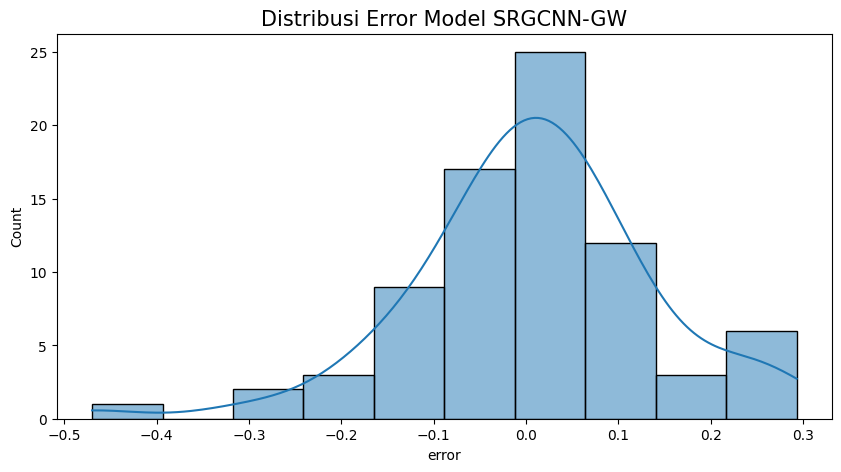

In [298]:
# Error distribution
plt.figure(figsize=(10, 5))
sns.histplot(dbplot_test['error'], bins=10, kde=True)
plt.title("Distribusi Error Model SRGCNN-GW", size=15)
plt.show()

In [296]:
# Normality Test using Kolmogorov-Smirnov
from scipy.stats import kstest

# Perform the Kolmogorov-Smirnov test
ks_stat, ks_pval = kstest(dbplot_test['error'], 'norm', args=(dbplot_test['error'].mean(), dbplot_test['error'].std()))

# Print the results
print(f"KS Statistic: {ks_stat}")
print(f"KS p-value: {ks_pval}")

KS Statistic: 0.07698220319727739
KS p-value: 0.7150605535518211


## Model Pembanding: SRGCNN

In [235]:
# Example of modifying the model_gcn architecture
model_gcn = GCN(n_features, n_labels, hidden=[n_features, 4*n_features, 8*n_features], dropouts=[0.1, 0.3, 0.5]).to(device)

# Example of modifying the optimizer learning rate
optimizer = torch.optim.Adam(model_gcn.parameters(), lr=0.01, weight_decay=0.001)

# Initialize early stopping
early_stopping = EarlyStopping(patience=2000, verbose=True)

# Initialize variables for tracking the lowest MAPE
lowest_mean_global_MAPE = np.inf

train_loss_arr = []
mape_arr = []
min_global_MAPE_epoch = -1

for i in range(epochs):
    train_loss = step(model_gcn, optimizer, x_tensor, train_idx, y_tensor, adj)
    train_loss_arr.append(train_loss)
    
    global_MAPE = evaluate_MAPE(model_gcn, x_tensor, val_idx, y_tensor, adj)
    mape_arr.append(global_MAPE * 100)

    if global_MAPE < lowest_mean_global_MAPE:
        lowest_mean_global_MAPE = global_MAPE
        output, target = return_results(model_gcn, x_tensor, test_idx, y_tensor, adj)
        min_global_MAPE_epoch = i

    # Call early stopping
    early_stopping(global_MAPE)

    if early_stopping.early_stop:
        print(f"Early stopping at epoch {i}")
        break

    if i % 1000 == 0 or i == epochs - 1:
        print(f"Epoch: {i} -- Train Loss: {train_loss:.4f} -- Global MAPE: {global_MAPE * 100:.4f}%")

Epoch: 0 -- Train Loss: 0.0778 -- Global MAPE: 300.3870%
Epoch: 1000 -- Train Loss: 0.0203 -- Global MAPE: 129.4473%
Epoch: 2000 -- Train Loss: 0.0204 -- Global MAPE: 135.8307%
Epoch: 3000 -- Train Loss: 0.0207 -- Global MAPE: 130.5863%
Epoch: 4000 -- Train Loss: 0.0203 -- Global MAPE: 136.8710%
Early stopping activated.
Early stopping at epoch 4029


In [236]:
# Assuming your model_gcn is trained and named `model_gcn`
weights = model_gcn.layers[0].weight.data  # Access weights of the first layer
importance = torch.abs(weights).sum(dim=1)  # Summing the absolute weights

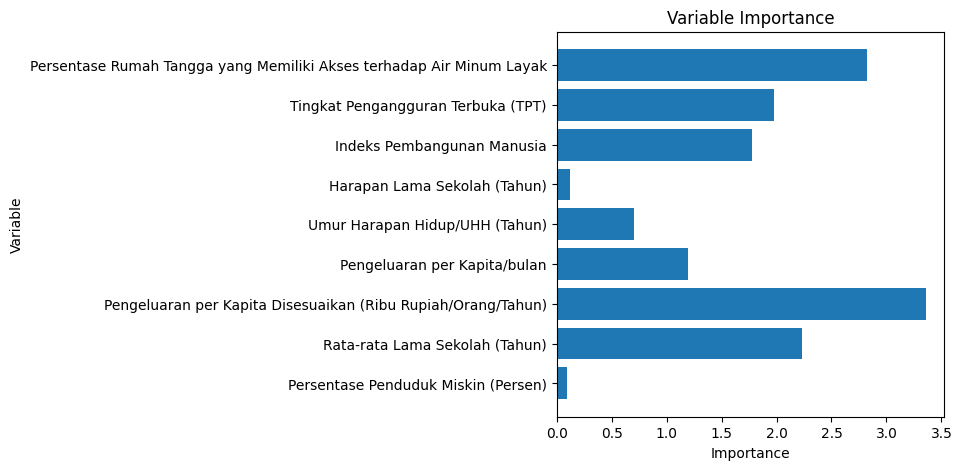

In [245]:
# Plot the importance
plt.figure(figsize=(5, 5))
plt.barh(variable_names, importance.cpu().numpy())
plt.xlabel("Importance")
plt.ylabel("Variable")
plt.title("Variable Importance")
plt.show()

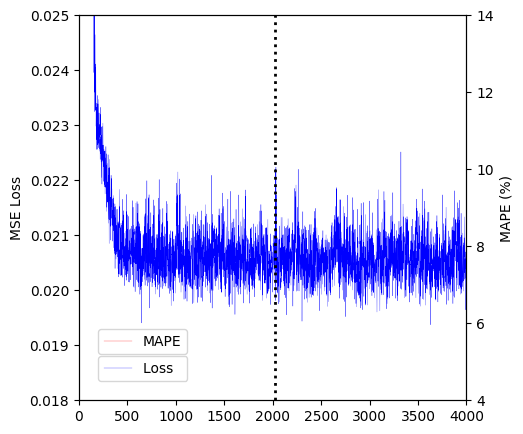

In [244]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(train_loss_arr,lw=0.2,color='b',alpha=1,label='Loss  ')
ax.set_xlim([0,4000])
ax.set_ylim([0.018,0.025])
ax2=ax.twinx()
ax2.plot(mape_arr,lw=0.2,color='r',alpha=1,label='MAPE')
ax2.set_ylim([4,14])
ax2.legend(loc=(0.05,0.12))
ax.legend(loc=(0.05,0.05))
ax.set_ylabel('MSE Loss')
ax2.set_ylabel('MAPE (%)')
plt.axvline(min_global_MAPE_epoch, linestyle="dotted", linewidth=2, color='black')

### 6. Output Statistics

The best results are recorded in the output array

In [246]:
mape=(mae(output,target)/target).mean()
mape # mean absolute percentage error between predicted y and the real y

0.11599564

Model goodness of fit

In [247]:
SSE=np.sum((target-output)**2)
SST=np.sum((db[['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak']].values-db[['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak']].values.mean())**2)

Rsq=1-SSE/SST
Rsq # R-square of model fit

0.9097795699448294

Moran's I of the model errors

In [248]:
print(output.shape)
print(target.shape)

(78, 1)
(78, 1)


In [249]:
import libpysal as ps
from libpysal.weights import KNN

# Extract test data from db using the test indices
db_test = db.iloc[test_idx.cpu()]

# Create KNN spatial weights matrix based on the test set geometries
knn_test = KNN.from_dataframe(db_test, geom_col='geometry', k=20)

# Check the created KNN
print(knn_test)

# Optional: if you want to visualize or verify the weights matrix
print(knn_test.full()[0])  # This will show the adjacency matrix form

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [1. 0. 0. ... 0. 1. 0.]
 ...
 [0. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]]


In [250]:
Ierror = esda.moran.Moran(output-target, knn_test)
print('Errors  moransI: '+str(Ierror.I)+'  Z_I: '+str(Ierror.z_norm)+' p-value: '+str(Ierror.p_sim))

Errors  moransI: 0.01220405528662007  Z_I: 0.8814049037196382 p-value: 0.151


### 7. Visualization

In [251]:
output

array([[0.9354842 ],
       [0.7462493 ],
       [0.63030535],
       [0.7281679 ],
       [0.7243183 ],
       [0.87967545],
       [0.8181431 ],
       [0.83217996],
       [0.7368017 ],
       [0.74596477],
       [0.7881597 ],
       [0.5547114 ],
       [0.7532991 ],
       [0.8579501 ],
       [0.86837107],
       [0.7836345 ],
       [0.68494874],
       [0.89501816],
       [0.814518  ],
       [0.72022194],
       [0.7776551 ],
       [0.8410788 ],
       [0.6829883 ],
       [0.8027328 ],
       [0.6840345 ],
       [0.6979057 ],
       [0.7529926 ],
       [0.8439527 ],
       [0.73141044],
       [0.7091851 ],
       [0.88045067],
       [0.8038642 ],
       [0.7328727 ],
       [0.8367167 ],
       [0.8370569 ],
       [0.73910314],
       [0.56956404],
       [0.8857795 ],
       [0.6008577 ],
       [0.7829214 ],
       [0.7918162 ],
       [0.8612671 ],
       [0.67250174],
       [0.7368017 ],
       [0.7217771 ],
       [0.8395151 ],
       [0.9026144 ],
       [0.714

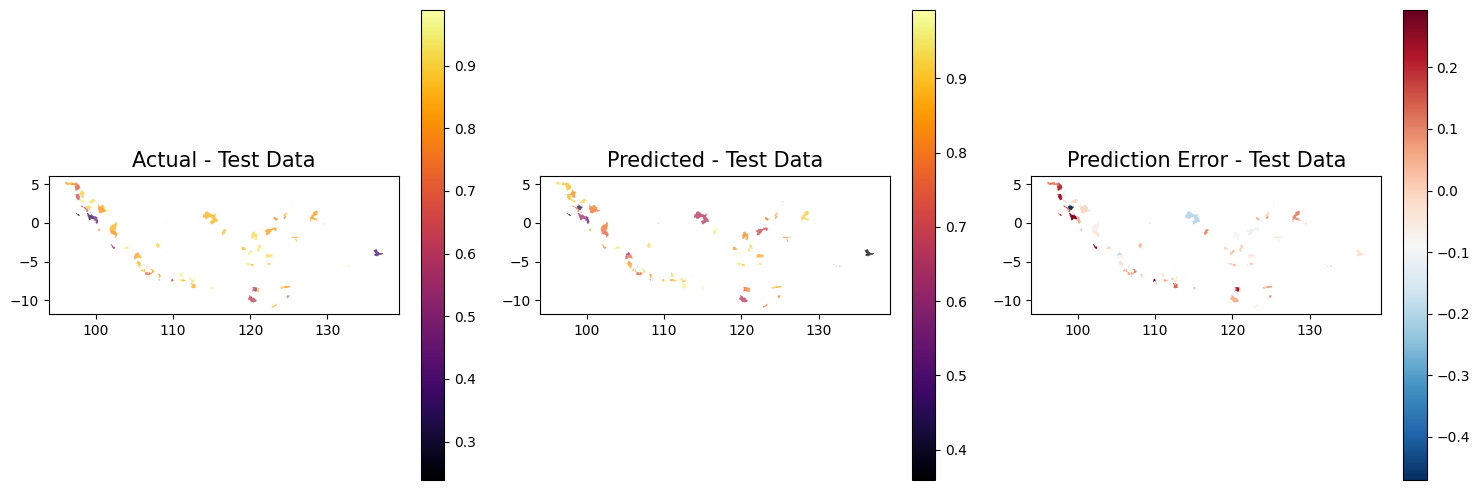

In [286]:
# Extract test data
dbplot_test = db_test.loc[:, ['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak', 'geometry']].copy()
dbplot_test['pred'] = output  # predicted values for the test set
dbplot_test['error'] = output - db_test[['Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak']].values  # errors for the test set

# Create a figure for plotting
f, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot real values of 'Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak'
dbplot_test.plot(column='Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak', cmap='inferno', alpha=0.75, legend=True, ax=ax[0])
ax[0].set_title('Actual - Test Data', fontsize=15)

# Plot predicted values from the model
dbplot_test.plot(column='pred', cmap='inferno', alpha=0.75, legend=True, ax=ax[1])
ax[1].set_title('Predicted - Test Data', fontsize=15)

# Plot errors (actual - predicted)
dbplot_test.plot(column='error', cmap='RdBu_r', alpha=1, legend=True, ax=ax[2])
ax[2].set_title('Prediction Error - Test Data', fontsize=15)

# Display the plots
plt.tight_layout()
plt.show()

In [177]:
# Min and max prediction absolute error
abs_error = np.abs(output - target)
min_error = np.min(abs_error)
max_error = np.max(abs_error)

print(f"Min error: {min_error}")
print(f"Max error: {max_error}")

Min error: 0.0012812614440917969
Max error: 0.5040251016616821


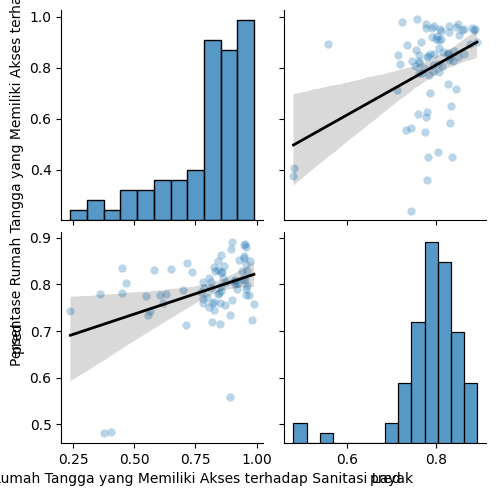

In [179]:
# Buat pairplot tanpa kolom 'error', jika ada
sns.pairplot(dbplot_test.drop('error', axis=1, errors='ignore'), 
             diag_kind="hist", 
             kind='reg', 
             plot_kws={'scatter_kws': {'linewidths': 0, 'alpha': 0.3}, 
                        'line_kws': {'color': 'black', 'lw': 2}})


## Model Pembanding Lain

In [162]:
# Simple linear regression
import statsmodels.api as sm

# Define the dependent and independent variables
train_X = db.loc[train_idx.cpu().numpy(), variable_names]
train_X = sm.add_constant(train_X)
train_y = db.loc[train_idx.cpu().numpy(), 'Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak']

# Fit the model
model = sm.OLS(train_y, train_X).fit()

# Print the summary
print(model.summary())

                                                     OLS Regression Results                                                    
Dep. Variable:     Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak   R-squared:                       0.617
Model:                                                                             OLS   Adj. R-squared:                  0.608
Method:                                                                  Least Squares   F-statistic:                     62.57
Date:                                                                 Sat, 05 Oct 2024   Prob (F-statistic):           1.85e-67
Time:                                                                         18:59:58   Log-Likelihood:                 272.11
No. Observations:                                                                  359   AIC:                            -524.2
Df Residuals:                                                                      349   BIC:           

In [163]:
# Predict the test set
test_X = db.loc[test_idx.cpu().numpy(), variable_names]
test_X = sm.add_constant(test_X)
test_y = db.loc[test_idx.cpu().numpy(), 'Persentase Rumah Tangga yang Memiliki Akses terhadap Sanitasi Layak']

# Predict the test set
test_pred = model.predict(test_X)

# Calculate the MAPE
mape = np.mean(np.abs(test_pred - test_y) / test_y)

# Print the MAPE
print('MAPE:', mape)

# Calculate R2
R2 = model.rsquared
print('R2:', R2)

MAPE: 0.15891757055368547
R2: 0.6173700911017956


In [164]:
# XGBoost Regression
from xgboost import XGBRegressor

# Define the model
model = XGBRegressor()

# Fit the model
model.fit(train_X, train_y)

# Predict the test set
test_pred = model.predict(test_X)

# Calculate the MAPE
mape = np.mean(np.abs(test_pred - test_y) / test_y)

# Print the MAPE
print('MAPE:', mape)

# Calculate R2
R2 = model.score(test_X, test_y)

# Print the R2
print('R2:', R2)

MAPE: 0.16011369743598558
R2: 0.3618464713534102


In [165]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

# Define the model
model = DecisionTreeRegressor()

# Fit the model
model.fit(train_X, train_y)

# Predict the test set
test_pred = model.predict(test_X)

# Calculate the MAPE
mape = np.mean(np.abs(test_pred - test_y) / test_y)

# Print the MAPE
print('MAPE:', mape)

# Calculate R2
R2 = model.score(test_X, test_y)

# Print the R2
print('R2:', R2)

MAPE: 0.22208619698656754
R2: -0.4498534483553738


In [166]:
# CatBoost Regression
from catboost import CatBoostRegressor

# Define the model
model = CatBoostRegressor()

# Fit the model
model.fit(train_X, train_y)

# Predict the test set
test_pred = model.predict(test_X)

# Calculate the MAPE
mape = np.mean(np.abs(test_pred - test_y) / test_y)

# Print the MAPE
print('MAPE:', mape)

# Calculate R2
R2 = model.score(test_X, test_y)

# Print the R2
print('R2:', R2)

Learning rate set to 0.034824
0:	learn: 0.1805447	total: 136ms	remaining: 2m 15s
1:	learn: 0.1777428	total: 137ms	remaining: 1m 8s
2:	learn: 0.1747493	total: 138ms	remaining: 46s
3:	learn: 0.1718402	total: 140ms	remaining: 34.8s
4:	learn: 0.1689040	total: 142ms	remaining: 28.2s
5:	learn: 0.1664004	total: 143ms	remaining: 23.7s
6:	learn: 0.1635618	total: 145ms	remaining: 20.5s
7:	learn: 0.1609487	total: 146ms	remaining: 18.1s
8:	learn: 0.1585500	total: 147ms	remaining: 16.2s
9:	learn: 0.1561991	total: 148ms	remaining: 14.7s
10:	learn: 0.1540331	total: 150ms	remaining: 13.5s
11:	learn: 0.1519079	total: 151ms	remaining: 12.4s
12:	learn: 0.1498373	total: 152ms	remaining: 11.6s
13:	learn: 0.1479633	total: 153ms	remaining: 10.8s
14:	learn: 0.1461793	total: 155ms	remaining: 10.2s
15:	learn: 0.1442095	total: 156ms	remaining: 9.59s
16:	learn: 0.1423886	total: 157ms	remaining: 9.09s
17:	learn: 0.1408333	total: 159ms	remaining: 8.66s
18:	learn: 0.1392752	total: 160ms	remaining: 8.26s
19:	learn: 0

In [167]:
# ANN Regression
from sklearn.neural_network import MLPRegressor

# Define the model
model = MLPRegressor()

# Fit the model
model.fit(train_X, train_y)

# Predict the test set
test_pred = model.predict(test_X)

# Calculate the MAPE
mape = np.mean(np.abs(test_pred - test_y) / test_y)

# Print the MAPE
print('MAPE:', mape)

# Calculate R2
R2 = model.score(test_X, test_y)

# Print the R2
print('R2:', R2)

MAPE: 0.2100400053785637
R2: -0.06482956829700814


In [278]:
# T-Test
from scipy.stats import ttest_ind

# Define the two groups
mape1 = 11.60
mape2 = 8.50
r21 = 90.98
r22 = 92.14

# Perform the t-test
t_stat, p_val = ttest_ind([mape1, r21], [mape2, r22])

# Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_val)

# ANOVA
from scipy.stats import f_oneway

# Define the three groups
mape1 = 11.60
mape2 = 8.50
mape3 = 15.89
mape4 = 16.01
mape5 = 22.21
mape6 = 14.22
mape7 = 21.00
r21 = 90.98
r22 = 92.14
r23 = 61.74
r24 = 36.28
r25 = 44.98
r26 = 47.59
r27 = 6.48

# Perform the ANOVA

f_stat, p_val = f_oneway([mape1, mape2, mape3, mape4, mape5, mape6, mape7], [r21, r22, r23, r24, r25, r26, r27])

# Print the results
print('F-Statistic:', f_stat)
print('P-Value:', p_val)

T-Statistic: 0.016823935955815154
P-Value: 0.9881045225079403
F-Statistic: 10.990635806324343
P-Value: 0.006164587035069117


In [280]:
import numpy as np
from scipy import stats

# Data MAPE untuk masing-masing model
mape_srgcnn = 11.60
mape_srgcnn_gw = 8.50
mape_regresi_linear = 15.89
mape_decision_tree = 16.01
mape_xgboost = 22.21
mape_catboost = 14.22
mape_mlp = 21.00

# Uji t antara SRGCNN dan model lainnya (misalnya, Regresi Linear)
t_statistic, p_value = stats.ttest_ind(
    [mape_srgcnn],
    [mape_regresi_linear],
    equal_var=False
)

print(f"Uji t antara SRGCNN dan Regresi Linear: t = {t_statistic:.4f}, p-value = {p_value:.4f}")


Uji t antara SRGCNN dan Regresi Linear: t = nan, p-value = nan


In [281]:
from scipy.stats import f_oneway

# Data MAPE untuk semua model
mape_values = [
    mape_srgcnn,
    mape_srgcnn_gw,
    mape_regresi_linear,
    mape_decision_tree,
    mape_xgboost,
    mape_catboost,
    mape_mlp
]

# ANOVA
f_statistic, p_value_anova = f_oneway(
    [mape_srgcnn],
    [mape_srgcnn_gw],
    [mape_regresi_linear],
    [mape_decision_tree],
    [mape_xgboost],
    [mape_catboost],
    [mape_mlp]
)

print(f"ANOVA: F = {f_statistic:.4f}, p-value = {p_value_anova:.4f}")

ANOVA: F = nan, p-value = nan


In [279]:
# Multiple comparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Define the data
data = [mape1, mape2, mape3, mape4, mape5, mape6, mape7, r21, r22, r23, r24, r25, r26, r27]
groups = ['mape1', 'mape2', 'mape3', 'mape4', 'mape5', 'mape6', 'mape7', 'r21', 'r22', 'r23', 'r24', 'r25', 'r26', 'r27']

# Perform the Tukey HSD test
tukey_results = pairwise_tukeyhsd(data, groups)

# Print the results
print(tukey_results)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower upper reject
-----------------------------------------------
 mape1  mape2     -3.1   nan   nan   nan  False
 mape1  mape3     4.29   nan   nan   nan  False
 mape1  mape4     4.41   nan   nan   nan  False
 mape1  mape5    10.61   nan   nan   nan  False
 mape1  mape6     2.62   nan   nan   nan  False
 mape1  mape7      9.4   nan   nan   nan  False
 mape1    r21    79.38   nan   nan   nan  False
 mape1    r22    80.54   nan   nan   nan  False
 mape1    r23    50.14   nan   nan   nan  False
 mape1    r24    24.68   nan   nan   nan  False
 mape1    r25    33.38   nan   nan   nan  False
 mape1    r26    35.99   nan   nan   nan  False
 mape1    r27    -5.12   nan   nan   nan  False
 mape2  mape3     7.39   nan   nan   nan  False
 mape2  mape4     7.51   nan   nan   nan  False
 mape2  mape5    13.71   nan   nan   nan  False
 mape2  mape6     5.72   nan   nan   nan  False
 mape2  mape7     12.5   nan   nan  